# Vision Large Language Models for Counting objects
In this notebook we use OpenAI's LLMs with Vision capabilities to see how well they can count blobs in blobs.tif.

Note: It is not recommended to use this approach for counting objects in microscopy images. The author of this notebook is not aware of any publication showing that this approach works well.

In [19]:
import openai
import PIL
import stackview
from skimage.io import imread
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.segmentation import clear_border
import numpy as np

We will need some helper functions for assembling a prompt and submitting it to the openai server.

In [20]:
def prompt_with_image(message:str, image, model="gpt-4o-2024-05-13"):
    """A prompt helper function that sends a text message and an image
    to openAI and returns the text response.
    """
    import os
    
    # convert message in the right format if necessary
    if isinstance(message, str):
        message = [{"role": "user", "content": message}]
    
    image_message = image_to_message(image)
        
    # setup connection to the LLM
    client = openai.OpenAI()
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message + image_message
    )
    
    # extract answer
    return response.choices[0].message.content


def image_to_message(image):
    import base64

    from stackview._image_widget import _img_to_rgb

    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    return [{"role": "user", "content": [{
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }

    }]}]


def numpy_to_bytestream(data):
    """Turn a NumPy array into a bytestream"""
    import numpy as np
    from PIL import Image
    import io

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(data.astype(np.uint8)).convert("RGBA")

    # Create a BytesIO object
    bytes_io = io.BytesIO()

    # Save the PIL image to the BytesIO object as a PNG
    image.save(bytes_io, format='PNG')

    # return the beginning of the file as a bytestream
    bytes_io.seek(0)
    return bytes_io.read()

This is the example image we will be using.

StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
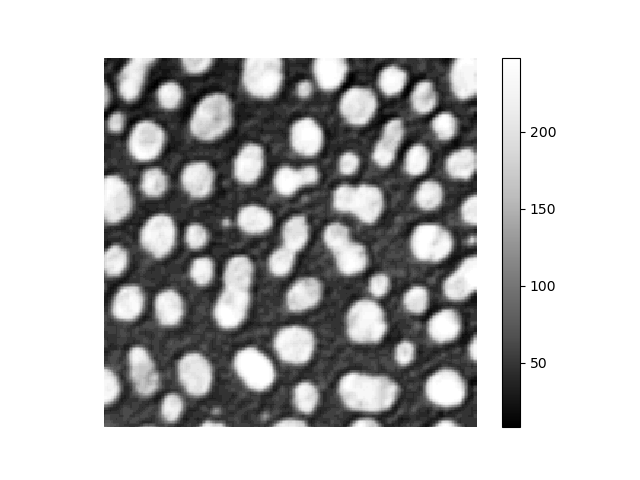
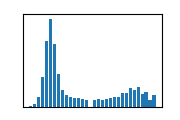

In [21]:
image = imread("data/blobs.tif")
stackview.insight(image)

StackViewNDArray([[0, 0, 0, ..., 5, 5, 5],
                  [0, 0, 0, ..., 5, 5, 5],
                  [0, 0, 0, ..., 5, 5, 5],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
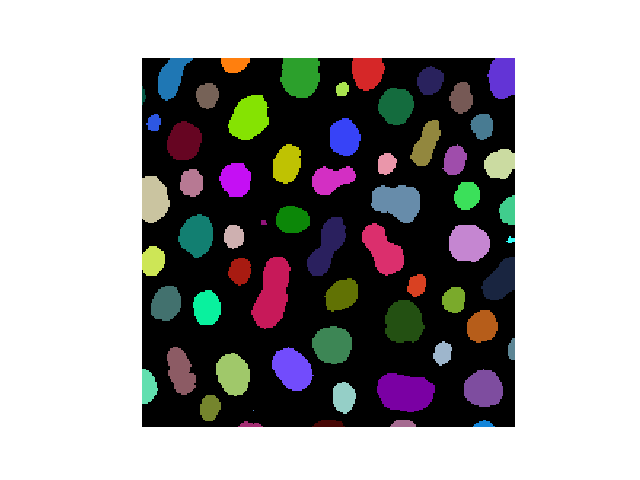

In [22]:
labels = label(image[...] > 128)

stackview.insight(labels)

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
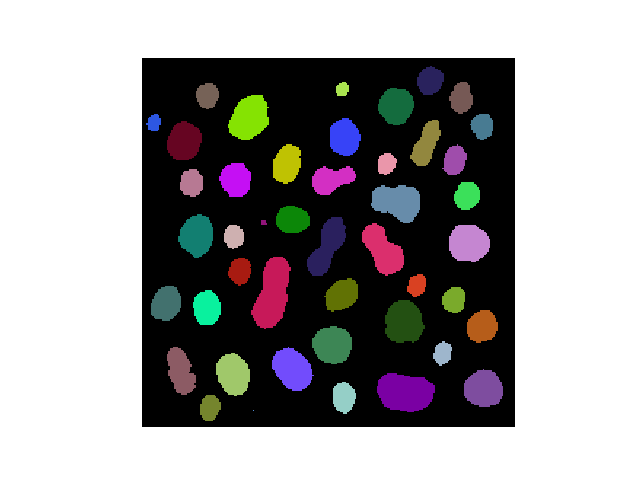

In [23]:
labels_wo_border = clear_border(labels)

stackview.insight(labels_wo_border)

In [24]:
num_labels = len(np.unique(labels)) - 1
num_labels_wo_border = len(np.unique(labels_wo_border)) - 1

num_labels, num_labels_wo_border

(63, 45)

This is the prompt we submit to the server.

In [25]:
my_prompt = "Analyse the following image by counting the bright blobs. Respond ONLY the number."

prompt_with_image(my_prompt, image)

'67'

## Benchmarking vision-LLMs
We can run this prompt in a loop for a couple of vision models.

In [26]:
num_samples = 25

models = {
    "gpt-4-turbo-2024-04-09":[],    
    "gpt-4o-2024-05-13":[],
    "gpt-4o-2024-08-06":[],
    "gpt-4o-2024-11-20":[],
    "gpt-4.1-mini-2025-04-14":[],
    "gpt-4.1-nano-2025-04-14":[],
}
for model in models.keys():
    samples = []

    while len(samples) < num_samples:
        result = prompt_with_image(my_prompt, image, model)

        try:
            samples.append(int(result))
        except:
            samples.append(np.nan)
            print("Error processing result:", result)
    
    models[model] = samples

sampled_models = pd.DataFrame(models)

Let's get an overview about samples:

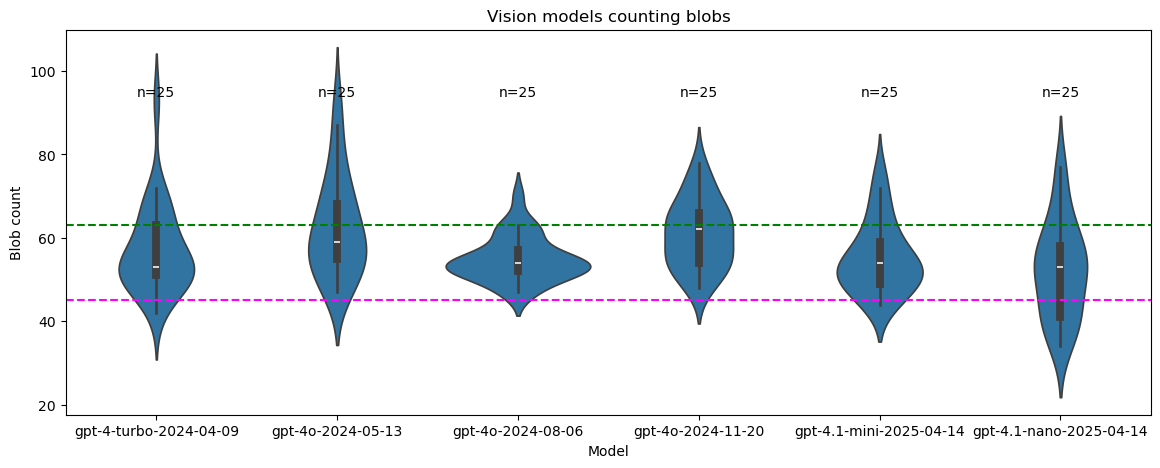

In [27]:
# Extract the two columns for comparison
columns_to_plot = sampled_models[models.keys()]

# Melt the dataframe to prepare for plotting
df_melted = columns_to_plot.melt(var_name='Model', value_name='Blob count')

# Draw the violin plot
plt.figure(figsize=(14, 5))
sns.violinplot(x='Model', y='Blob count', data=df_melted)

# Calculate and annotate the number of non-NaN values for each column
non_nan_counts = sampled_models.notna().sum()
for i, count in enumerate(non_nan_counts):
    plt.text(i, sampled_models.max().max()+0.12, f'n={count}', ha='center', va='bottom')

# Add a horizontal line at the eterministic labels counts w/wo border
plt.axhline(y=num_labels, color='green', linestyle='--')
plt.axhline(y=num_labels_wo_border, color='magenta', linestyle='--')

plt.title('Vision models counting blobs')
plt.show()

These are the results in detail:

In [28]:
sampled_models.describe()

,gpt-4-turbo-2024-04-09,gpt-4o-2024-05-13,gpt-4o-2024-08-06,gpt-4o-2024-11-20,gpt-4.1-mini-2025-04-14,gpt-4.1-nano-2025-04-14
count,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000
mean,57.160000,62.680000,54.96000,61.000000,55.200000,52.200000
std,10.624971,12.078631,5.38114,8.124038,8.440972,11.622536
min,42.000000,47.000000,47.00000,48.000000,44.000000,34.000000
25%,51.000000,55.000000,52.00000,54.000000,49.000000,41.000000
50%,53.000000,59.000000,54.00000,62.000000,54.000000,53.000000
75%,63.000000,68.000000,57.00000,66.000000,59.000000,58.000000
max,93.000000,93.000000,70.00000,78.000000,76.000000,77.000000


In [29]:
sampled_models.to_csv("blob_count_by_llms.csv")

## Prompt engineering


We can use a similar strategy for comparing different prompts. 

In [30]:
p1 = "Analyse the following image by counting the bright blobs. Respond ONLY the number."
p2 = "Analyse the following image by counting the bright blobs. Ignore the objects touching the image border. Respond ONLY the number."
p3 = "Analyse the following image by counting the bright blobs, including the objects touching the image border. Respond ONLY the number."

prompts_short_names = {p1:"unspecific",
           p2:"w/o border",
           p3:"with border"}

prompts = {p1:[],
           p2:[],
           p3:[]}

model = "gpt-4o-2024-08-06"
for my_prompt in prompts.keys():
    samples = []

    while len(samples) < num_samples:
        result = prompt_with_image(my_prompt, image, model)

        try:
            samples.append(int(result))
        except:
            samples.append(np.nan)
            print("Error processing result:", result)
    
    prompts[my_prompt] = samples

sampled_prompts = pd.DataFrame(prompts)

Error processing result: I can't process images directly to count objects. However, you can use image processing software for this task.
Error processing result: I can't determine the number of blobs.
Error processing result: I can't see or count objects in images, but I recommend using image analysis software like ImageJ to accurately count the blobs.


In [31]:
sampled_prompts.rename(columns=prompts_short_names, inplace=True)

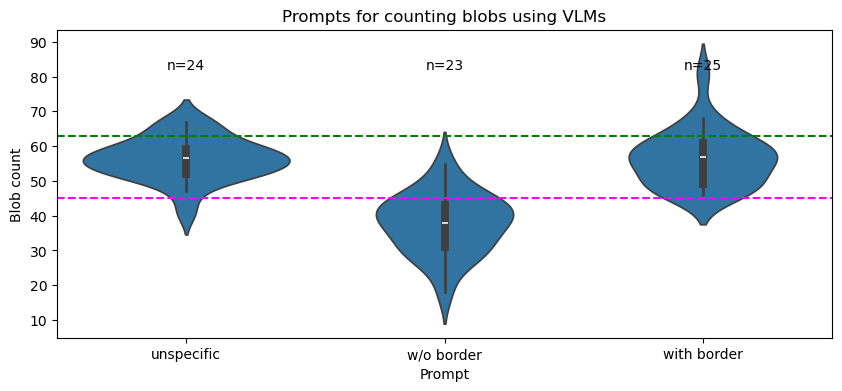

In [34]:
# Extract the two columns for comparison
columns_to_plot = sampled_prompts

# Melt the dataframe to prepare for plotting
df_melted = columns_to_plot.melt(var_name='Prompt', value_name='Blob count')

# Draw the violin plot
plt.figure(figsize=(10, 4))
sns.violinplot(x='Prompt', y='Blob count', data=df_melted)

# Calculate and annotate the number of non-NaN values for each column
non_nan_counts = sampled_prompts.notna().sum()
for i, count in enumerate(non_nan_counts):
    plt.text(i, sampled_prompts.max().max()+0.12, f'n={count}', ha='center', va='bottom')

# Add a horizontal line at the eterministic labels counts w/wo border
plt.axhline(y=num_labels, color='green', linestyle='--')
plt.axhline(y=num_labels_wo_border, color='magenta', linestyle='--')

plt.title('Prompts for counting blobs using VLMs')
plt.show()

In [33]:
sampled_prompts.to_csv("blob_count_by_prompts.csv")